In [23]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
# Install prerequisites

# Install PyCocoTools needed for FasterRCNN
!pip install git+https://github.com/gautamchitnis/cocoapi.git@cocodataset-master#subdirectory=PythonAPI

# Copy useful functions from pytorch vision tools
%cp ../input/pytorch-vision-tools/references/detection/*.* .

  Cloning https://github.com/gautamchitnis/cocoapi.git (to revision cocodataset-master) to /tmp/pip-req-build-5yrrvzr7
  Running command git clone -q https://github.com/gautamchitnis/cocoapi.git /tmp/pip-req-build-5yrrvzr7
  Running command git checkout -b cocodataset-master --track origin/cocodataset-master
  Switched to a new branch 'cocodataset-master'
  Branch 'cocodataset-master' set up to track remote branch 'cocodataset-master' from 'origin'.
cp: cannot stat '../input/pytorch-vision-tools/references/detection/*.*': No such file or directory


In [25]:
# Import required libraries
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image, ImageFont, ImageDraw, ImageEnhance
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from os import path
import torch
import torchvision.utils
# import utils
# from engine import train_one_epoch, evaluate
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.optim import Adam
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import pickle
import time
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [26]:
class_dictionary = {
    0: 'No finding',
    1: 'Aortic enlargement',
    2: 'Atelectasis',
    3: 'Calcification',
    4: 'Cardiomegaly',
    5: 'Consolidation',
    6: 'ILD',
    7: 'Infiltration',
    8: 'Lung Opacity',
    9: 'Nodule/Mass',
    10: 'Other lesion',
    11: 'Pleural effusion',
    12: 'Pleural thickening',
    13: 'Pneumothorax',
    14: 'Pulmonary fibrosis'
}

color_dictionary = {
    0: (0, 0, 0),
    1: (245, 130, 48),
    2: (255,225,25),
    3: (210, 245, 60),
    4: (60, 180, 75),
    5: (70, 240, 240),
    6: (0, 130, 200),
    7: (145, 30, 180),
    8: (220, 190, 255),
    9: (128, 128, 0),
    10: (240, 50, 230),
    11: (230, 25, 75),
    12: (128, 0, 0),
    13: (0, 128, 128),
    14: (170, 255, 195)
}

# Training

In [27]:
df_train = pd.read_csv(f"../input/vinbigdata-chest-xray-abnormalities-detection/train.csv")
df_train

,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max
0,50a418190bc3fb1ef1633bf9678929b3,No finding,14,R11,NaN,NaN,NaN,NaN
1,21a10246a5ec7af151081d0cd6d65dc9,No finding,14,R7,NaN,NaN,NaN,NaN
2,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,R10,691.0,1375.0,1653.0,1831.0
3,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,R10,1264.0,743.0,1611.0,1019.0
4,063319de25ce7edb9b1c6b8881290140,No finding,14,R10,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
67909,936fd5cff1c058d39817a08f58b72cae,No finding,14,R1,NaN,NaN,NaN,NaN
67910,ca7e72954550eeb610fe22bf0244b7fa,No finding,14,R1,NaN,NaN,NaN,NaN
67911,aa17d5312a0fb4a2939436abca7f9579,No finding,14,R8,NaN,NaN,NaN,NaN
67912,4b56bc6d22b192f075f13231419dfcc8,Cardiomegaly,3,R8,771.0,979.0,1680.0,1311.0


In [28]:
# len(df_train[df['image_id'].unique())
a = df_train[df_train['class_id'] == 14]
len(a['image_id'].unique())
# a['image_id'].nunique()

10606

In [29]:
a = df_train[df_train['class_id'] == 14]
len(a['image_id'])

31818

In [30]:
df_train.shape

(67914, 8)

In [31]:
df_train_image_count = pd.DataFrame()
for i in range(15):
    df_train_epoch = df_train[df_train['class_id'] == i]
    df_train_epoch = df_train_epoch.drop_duplicates(subset=['image_id'], keep='first')
    df_train_image_count = df_train_image_count.append(df_train_epoch, ignore_index=True)
    df_train_image_count.reset_index(drop=True, inplace=True)
no_of_images = []
for i in range(15):
    no_of_images.append(len(df_train_image_count[df_train_image_count['class_id'] == i]))
    print(len(df_train_image_count[df_train_image_count['class_id'] == i]))

3067
186
452
2300
353
386
613
1322
826
1134
1032
1981
96
1617
10606


In [32]:
sum(no_of_images)

25971

In [33]:
sum(no_of_images)

25971

In [34]:
colors= [
    (245, 130, 48),
    (255,225,25),
    (210, 245, 60),
    (60, 180, 75),
    (70, 240, 240),
    (0, 130, 200),
    (145, 30, 180),
    (220, 190, 255),
    (128, 128, 0),
    (240, 50, 230),
    (230, 25, 75),
    (128, 0, 0),
    (0, 128, 128),
    (170, 255, 195),
    (61, 64, 62)]

class_values = ['Aortic enlargement',
    'Atelectasis',
    'Calcification',
    'Cardiomegaly',
    'Consolidation',
    'ILD',
    'Infiltration',
    'Lung Opacity',
    'Nodule/Mass',
    'Other lesion',
    'Pleural effusion',
    'Pleural thickening',
    'Pneumothorax',
    'Pulmonary fibrosis',
    'No finding']

colors = [(e[0] / 255.0, e[1] / 255.0, e[2] / 255.0) for e in colors]
class_id = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])
image_count = np.array(no_of_images)
# convert to pandas dataframe
d = {'class_id': class_id, 'image_count': image_count}
lineplot_data = pd.DataFrame(d)

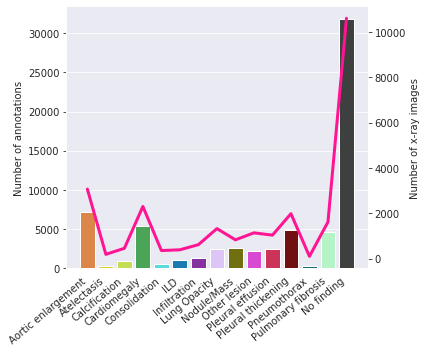

In [70]:
p = plt.figure(figsize=(6,5))
sns.set_palette(sns.color_palette(colors))
plt.xticks(np.arange(15), [i for i in class_values], rotation=40, ha='right')
# plot using lineplot
plot1 = sns.countplot(x='class_id', data=df_train)
plt.xlabel('')
plt.ylabel('Number of annotations')

plt.xticks(np.arange(15), [i for i in class_values])
plot2 = plot1.twinx()

# sns.set_palette(sns.color_palette([(0.75, 0.12, 0.13)]))
plot2 = sns.lineplot(x='class_id', y='image_count', data=lineplot_data, linewidth = 3, color='deeppink')
sns.set_style("darkgrid")
plot2.grid(None)

plt.xlabel('')
plt.ylabel('Number of x-ray images')
plt.tight_layout()
p.savefig("intial-distr.pdf")

# split

In [58]:
df_train_strat = pd.read_csv(f"../input/vinbig1024stratified-withnih/vinbigstratified_withnih/train.csv")
df_train_strat_sup = pd.read_csv(f"../input/vinbig1024stratified-withnih/vinbigstratified_withnih/train_sup.csv")
df_train_strat_sup_nih = pd.read_csv(f"../input/vinbig1024stratified-withnih/vinbigstratified_withnih/train_sup_with_nih.csv")
df_train_start_avg = pd.read_csv(f"../input/vinbig1024stratified-withnih/vinbigstratified_withnih/train_average.csv")

In [59]:
df_train_0 = df_train_strat[df_train_strat['class_id'] == 14]
df_train_no_0 = df_train_strat[df_train_strat['class_id'] != 14]
df_train_0_no_duplicates = df_train_0.drop_duplicates(subset=['image_id', 'class_id'], keep='first')
df_train_strat = df_train_no_0.append(df_train_0_no_duplicates, ignore_index=True)
df_train_strat.reset_index(drop=True, inplace=True)

annot_count_strat = []
for i in range(15):
    df_train_class_count = len(df_train_strat[df_train_strat['class_id'] == i])
    annot_count_strat.append(df_train_class_count)
# annot_count_strat = np.array([image_count_strat])
print(annot_count_strat)
print(sum(annot_count_strat))
image_count_strat = np.array(annot_count_strat)
d1 = {'class_id': class_id, 'image_count': image_count_strat}
data1 = pd.DataFrame(d1)

df_train_0 = df_train_strat_sup[df_train_strat_sup['class_id'] == 14]
df_train_no_0 = df_train_strat_sup[df_train_strat_sup['class_id'] != 14]
df_train_0_no_duplicates = df_train_0.drop_duplicates(subset=['image_id', 'class_id'], keep='first')
df_train_strat_sup = df_train_no_0.append(df_train_0_no_duplicates, ignore_index=True)
df_train_strat_sup.reset_index(drop=True, inplace=True)

annot_count_strat_sup = []
for i in range(15):
    df_train_class_count = len(df_train_strat_sup[df_train_strat_sup['class_id'] == i])
    annot_count_strat_sup.append(df_train_class_count)
# annot_count_strat_sup = np.array([image_count_strat])
print(annot_count_strat_sup)
print(sum(annot_count_strat_sup))
image_count_strat_sup = np.array(annot_count_strat_sup)
d2 = {'class_id': class_id, 'image_count': image_count_strat_sup}
data2 = pd.DataFrame(d2)


df_train_0 = df_train_strat_sup_nih[df_train_strat_sup_nih['class_id'] == 14]
df_train_no_0 = df_train_strat_sup_nih[df_train_strat_sup_nih['class_id'] != 14]
df_train_0_no_duplicates = df_train_0.drop_duplicates(subset=['image_id', 'class_id'], keep='first')
df_train_strat_sup_nih = df_train_no_0.append(df_train_0_no_duplicates, ignore_index=True)
df_train_strat_sup_nih.reset_index(drop=True, inplace=True)

annot_count_strat_sup_nih = []
for i in range(15):
    df_train_class_count = len(df_train_strat_sup_nih[df_train_strat_sup_nih['class_id'] == i])
    annot_count_strat_sup_nih.append(df_train_class_count)
# annot_count_strat_sup = np.array([image_count_strat])
print(annot_count_strat_sup_nih)
print(sum(annot_count_strat_sup_nih))
image_count_strat_sup_nih = np.array(annot_count_strat_sup_nih)
d3 = {'class_id': class_id, 'image_count': image_count_strat_sup_nih}
data3 = pd.DataFrame(d3)


df_train_0 = df_train_start_avg[df_train_start_avg['class_id'] == 14]
df_train_no_0 = df_train_start_avg[df_train_start_avg['class_id'] != 14]
df_train_0_no_duplicates = df_train_0.drop_duplicates(subset=['image_id', 'class_id'], keep='first')
df_train_start_avg = df_train_no_0.append(df_train_0_no_duplicates, ignore_index=True)
df_train_start_avg.reset_index(drop=True, inplace=True)

annot_count_strat_avg = []
for i in range(15):
    df_train_class_count = len(df_train_start_avg[df_train_start_avg['class_id'] == i])
    annot_count_strat_avg.append(df_train_class_count)
# annot_count_strat_sup = np.array([image_count_strat])
print(annot_count_strat_avg)
print(sum(annot_count_strat_avg))
image_count_strat_avg = np.array(annot_count_strat_avg)
d4 = {'class_id': class_id, 'image_count': image_count_strat_avg}
data4 = pd.DataFrame(d4)

[5736, 222, 783, 4324, 438, 775, 995, 1940, 1949, 1713, 1934, 3881, 163, 3753, 8480]
37086
[2463, 151, 465, 1851, 304, 477, 651, 1289, 998, 1126, 983, 2545, 78, 1841, 8480]
23702
[2463, 251, 465, 1929, 304, 477, 693, 1289, 1113, 1126, 1064, 2545, 141, 1841, 8480]
24181
[2921, 161, 524, 2738, 313, 506, 672, 1361, 1273, 1227, 1228, 2760, 87, 2191, 8480]
26442


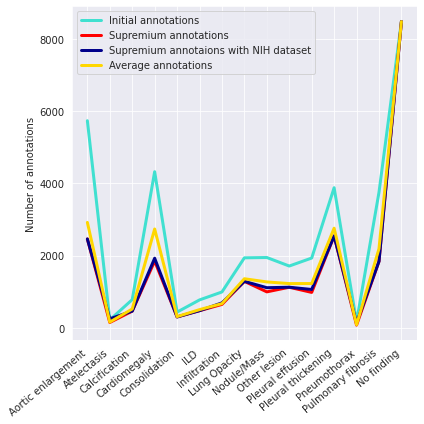

In [73]:
p = plt.figure(figsize=(6,6))
sns.set_palette(sns.color_palette(colors))
plt.xticks(np.arange(15), [i for i in class_values], rotation=40, ha='right')
# plot using lineplot
# plot1 = sns.countplot(x='class_id', data=df_train)
# plt.xlabel('')
# plt.ylabel('Number of annotations')

# plt.xticks(np.arange(15), [i for i in class_values])
# plot2 = plot1.twinx()

# sns.set_palette(sns.color_palette([(0.75, 0.12, 0.13)]))
plot = sns.lineplot(x='class_id', y='image_count', data=data1, linewidth = 3, color='turquoise')
sns.lineplot(x='class_id', y='image_count', data=data2, linewidth = 3, color='red')
sns.lineplot(x='class_id', y='image_count', data=data3, linewidth = 3, color='darkblue')
sns.lineplot(x='class_id', y='image_count', data=data4, linewidth = 3, color='gold')
sns.set_style("darkgrid")
plot.legend(['Initial annotations', 'Supremium annotations', 'Supremium annotaions with NIH dataset', 'Average annotations'])
# plot.grid(None)

plt.xlabel('')
plt.ylabel('Number of annotations')
plt.tight_layout()
p.savefig("intial-distr.pdf")
p.savefig("after-change.pdf")